# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [203]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import pandas as pd 

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [41]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)


(7000, 126) (1124, 126)
[0 0 0 ... 1 0 1]


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

numbers of principle components: 1  // explained total variance: 0.16404331279333917
numbers of principle components: 2  // explained total variance: 0.29727810148781075
numbers of principle components: 3  // explained total variance: 0.39901266670902324
numbers of principle components: 4  // explained total variance: 0.4696462310323465
numbers of principle components: 5  // explained total variance: 0.5083126829705809
numbers of principle components: 10  // explained total variance: 0.6522135551378362
numbers of principle components: 20  // explained total variance: 0.808890170282799
numbers of principle components: 30  // explained total variance: 0.898418891760153
numbers of principle components: 40  // explained total variance: 0.9509253504445883
numbers of principle components: 50  // explained total variance: 0.9821027576520666


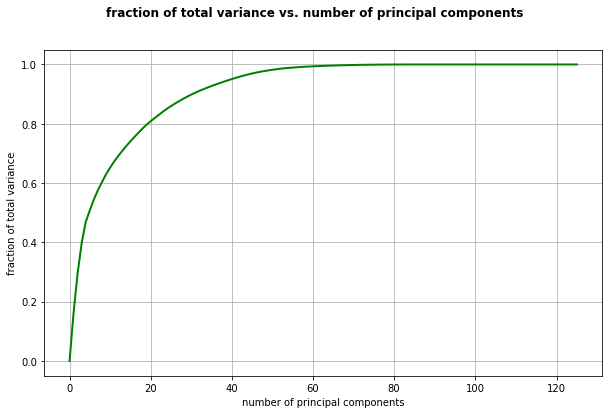

In [78]:
def P1():

## STUDENT START
    
    k_list = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    for k in k_list:
        pca = PCA(n_components=k)
        pca.fit_transform(train_data)
        print("numbers of principle components:", k
              ," // explained total variance:", pca.explained_variance_ratio_.sum())

    total_var = []
    k_list = list(range(0,test_data.shape[1]))
    for k in k_list:
        pca = PCA(n_components=k)
        pca.fit_transform(train_data)
        total_var.append(pca.explained_variance_ratio_.sum())
        
    # plot 
    fig = plt.figure(figsize=(10,6))
    fig.suptitle("fraction of total variance vs. number of principal components", fontweight="bold")
    plt.ylabel("fraction of total variance")
    plt.xlabel("number of principal components")
    plt.plot(k_list, total_var, color="green", linewidth=2)
    plt.grid()
    plt.show()





## STUDENT END ###

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

[[-1.05434423 -0.89426353]
 [-1.44383063 -0.08008493]
 [-1.54310157 -0.28842398]
 ...
 [-0.84782626 -0.5247954 ]
 [-1.0720459   0.2303479 ]
 [-0.4787399  -0.99965154]]


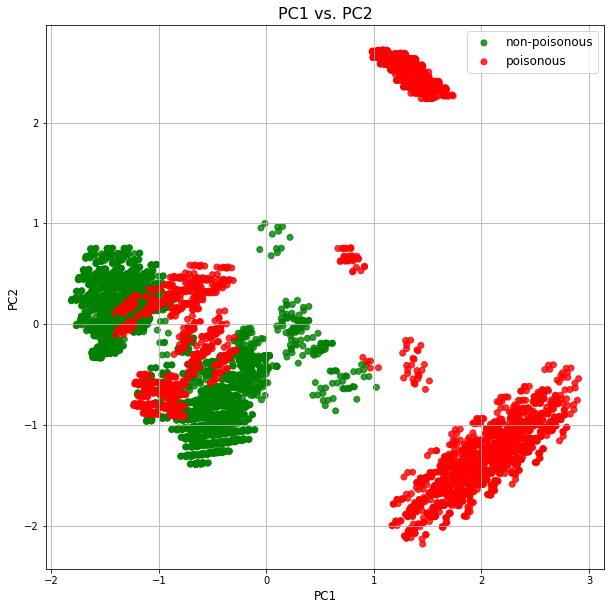

In [76]:
def P2():
## STUDENT START ###
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    print(PC)

  # plot 
    fig, ax = plt.subplots(figsize=(10,10)) 
    color = np.where(train_labels, 'red', 'green') 
    ax.scatter(PC[train_labels == 0 ,0],PC[train_labels == 0,1], 
               label = "non-poisonous", c=color[train_labels == 0], alpha = 0.8)
    ax.scatter(PC[train_labels == 1 ,0],PC[train_labels == 1,1], 
               label = "poisonous", c=color[train_labels == 1], alpha = 0.8)
    ax.legend(loc='best', fontsize=12)
    ax.set_title('PC1 vs. PC2', fontsize = 16) 
    ax.set_xlabel('PC1', fontsize = 12) 
    ax.set_ylabel('PC2', fontsize = 12) 
    ax.grid(True)

## STUDENT END ###

P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

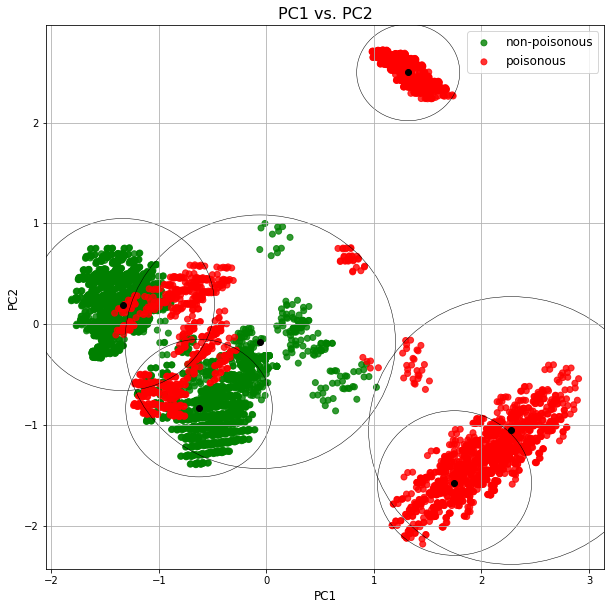

In [155]:
def P3():

## STUDENT START ###
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    cord = pca.transform(train_data)
    km = KMeans(n_clusters=6, random_state=0).fit(PC)
    y_pred = km.predict(PC)
    center = km.cluster_centers_
    
    # calculate distance to cluster 
    max_dist = []
    for i in range(0,6):
#         max_dist.append(np.max(np.linalg.norm(cord[y_pred == i] - center[i])))
        max_dist.append(np.max(np.sqrt(((cord[y_pred == i] - center[i])**2).sum(axis=1))))
    
    # plot data (PCs)
    fig, ax = plt.subplots(figsize=(10,10))
    color = np.where(train_labels, 'red', 'green') 
    ax.scatter(PC[train_labels == 0 ,0],PC[train_labels == 0,1], 
               label = "non-poisonous", c=color[train_labels == 0], alpha = 0.8)
    ax.scatter(PC[train_labels == 1 ,0],PC[train_labels == 1,1], 
               label = "poisonous", c=color[train_labels == 1], alpha = 0.8)
    
    # plot centroids
    ax.scatter(center[:,0], center[:,1], color = 'black')
    
    # plot circles
    for j in range(0,6):
        circle = plt.Circle(center[j], max_dist[j], color = 'black', lw = 0.5, fill = False)
        ax.add_artist(circle)
    
    ax.legend(loc='best', fontsize=12)
    ax.set_title('PC1 vs. PC2', fontsize = 16) 
    ax.set_xlabel('PC1', fontsize = 12) 
    ax.set_ylabel('PC2', fontsize = 12) 
    ax.grid(True)



## STUDENT END ###

P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-169-6c63ea4ad706>:33: UserWarning: Log scale: values of z <= 0 have been masked
  ax[ii][jj].contourf(X, Y, Z,norm=LogNorm(vmin=1, vmax=100),
No handles with labels found to put in legend.
<ipython-input-169-6c63ea4ad706>:33: UserWarning: Log scale: values of z <= 0 have been masked
  ax[ii][jj].contourf(X, Y, Z,norm=LogNorm(vmin=1, vmax=100),
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-169-6c63ea4ad706>:33: UserWarning: Log scale: values of z <= 0 have been masked
  ax[ii][jj].contourf(X, Y, Z,norm=LogNorm(vmin=1, vmax=100),
No handles with labels found to put in legend.
<ipython-input-169-6c63ea4ad706>:33: UserWarning: Log scale: values of z <= 0 have been masked
  ax[ii][jj].contourf(X, Y, Z,norm=LogNorm(vmin=1, vmax=10

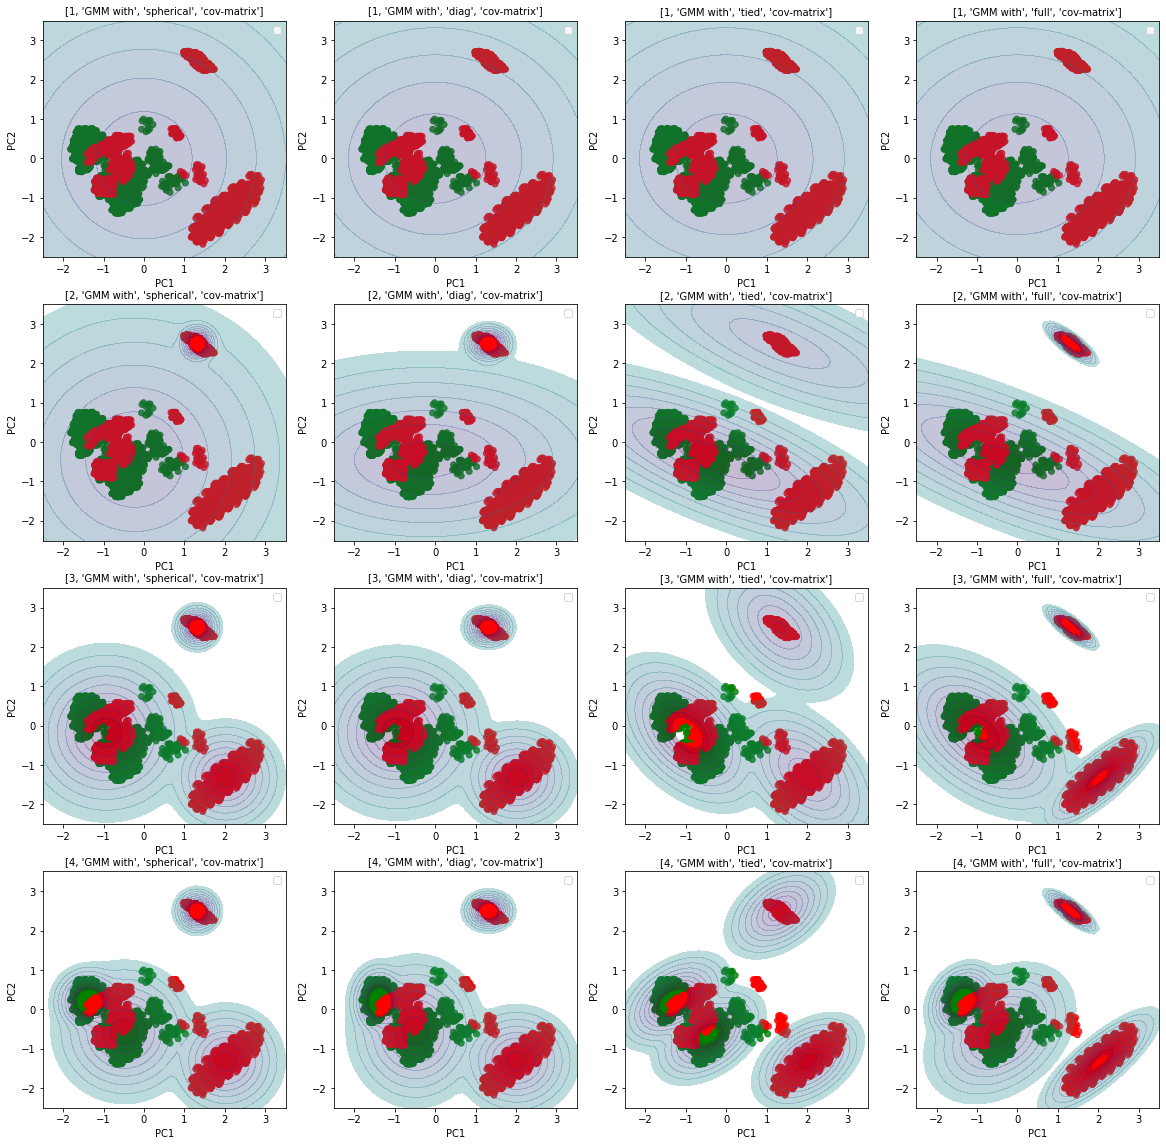

In [169]:
def P4():

## STUDENT START ###
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    cord = pca.transform(train_data)
    cov_type = ['spherical', 'diag', 'tied', 'full']
    c=0
    fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize=(20,20))
    for i in range(1,5): # cluster size
        ii = i - 1
        jj = 0
        for j in cov_type:
            gmm = GaussianMixture(n_components = i, covariance_type = j, random_state = 12345).fit(PC)
            y_pred = gmm.predict(PC)
            
            # plot
            x = np.linspace(-2.5, 3.5)
            y = np.linspace(-2.5, 3.5) 
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
        
            
            color = np.where(train_labels, 'red', 'green') 
            ax[ii][jj].scatter(PC[train_labels == 0 ,0],PC[train_labels == 0,1], 
                       c=color[train_labels == 0], alpha = 0.8)
            ax[ii][jj].scatter(PC[train_labels == 1 ,0],PC[train_labels == 1,1], 
                       c=color[train_labels == 1], alpha = 0.8)
    
            # plot contours
            ax[ii][jj].contourf(X, Y, Z,norm=LogNorm(vmin=1, vmax=100),
                                levels=np.logspace(0, 1, 10), alpha=.3)

            ax[ii][jj].legend(loc='best', fontsize=10)
            title = [i,"GMM with",j, "cov-matrix" ]
            ax[ii][jj].set_title(title, fontsize = 10) 
            ax[ii][jj].set_xlabel('PC1', fontsize = 10) 
            ax[ii][jj].set_ylabel('PC2', fontsize = 10) 
            
            jj =jj +1
            c=c+1



## STUDENT END ###

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [191]:
def P5():

## STUDENT START ###

    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    
    gmm_0 = GaussianMixture(n_components = 4, covariance_type = "full", 
                          random_state = 12345).fit(PC[train_labels == 0])
    gmm_1 = GaussianMixture(n_components = 4, covariance_type = "full", 
                          random_state = 12345).fit(PC[train_labels == 1])  
    # predict test data set
    PC_test = pca.transform(test_data)
    y_prob_0 = gmm_0.score_samples(PC_test)
    y_prob_1 = gmm_1.score_samples(PC_test)
    
    sign = y_prob_1 - y_prob_0
    y_pred = [1 if x> 0 else 0 for x in sign]
    acc = np.sum(y_pred == test_labels)/(PC_test.shape[0])
    print("accuracy of the GMM model:", acc)
    

## STUDENT END ###

P5()

accuracy of the GMM model: 0.9501779359430605


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [209]:
def P6():

## STUDENT START ###
    def gmm_acc(pca_n, gmm_n, cov_type):
        pca = PCA(n_components=pca_n)
        PC = pca.fit_transform(train_data)
        gmm_0 = GaussianMixture(n_components = gmm_n, covariance_type = cov_type, 
                          random_state = 12345).fit(PC[train_labels == 0])
        gmm_1 = GaussianMixture(n_components = gmm_n, covariance_type = cov_type, 
                          random_state = 12345).fit(PC[train_labels == 1])  
        
        PC_test = pca.transform(test_data)
        y_prob_0 = gmm_0.score_samples(PC_test)
        y_prob_1 = gmm_1.score_samples(PC_test)

        sign = y_prob_1 - y_prob_0
        y_pred = [1 if x> 0 else 0 for x in sign]
        acc = np.sum(y_pred == test_labels)/(PC_test.shape[0])

        return acc
    # main
    # loop through each combination 
    cov_type_list = ['spherical', 'diag', 'full']
    acc_list = []
    gmm_n_list = []
    pca_n_list = []
    cov_list = []
    for i in range(2,10): # PCA
        for j in range(2,10): # GMM
            for k in cov_type_list: 
                # calculate size of parameters
                par_size = ((2*i) * j * 2)               
                if par_size <= 50:
                    acc = gmm_acc(i, j, k)
                    acc_list.append(acc)
                    gmm_n_list.append(j)
                    pca_n_list.append(i)
                    cov_list.append(k)
                else:
                    continue
                
    # generate df for dispaly 
    df = pd.DataFrame({"PCA numbers":  pca_n_list,
                      "GMM numbers":  gmm_n_list,
                      "Cov Type" : cov_list,
                      "Accuracy" : acc_list})
    
    # sort and display df
    sorted_df = df.sort_values(by='Accuracy', ascending=False)
    # show top 25 combinition 
    print(sorted_df.head(25))

    

## STUDENT END ###

P6()

    PCA numbers  GMM numbers   Cov Type  Accuracy
35            6            2       full  0.966192
32            5            2       full  0.959964
21            3            4  spherical  0.959075
23            3            4       full  0.958185
11            2            5       full  0.957295
22            3            4       diag  0.953737
14            2            6       full  0.953737
8             2            4       full  0.950178
6             2            4  spherical  0.945730
12            2            6  spherical  0.943950
13            2            6       diag  0.942171
7             2            4       diag  0.939502
9             2            5  spherical  0.936833
4             2            3       diag  0.935943
3             2            3  spherical  0.933274
10            2            5       diag  0.932384
5             2            3       full  0.930605
19            3            3       diag  0.913701
27            4            3  spherical  0.911922
